<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/DPT_Github_and_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Requirements:

In [1]:
!git clone https://github.com/isl-org/DPT.git
%cd /content/DPT
!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt
!pip -q install timm

Cloning into 'DPT'...
remote: Enumerating objects: 776, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 776 (delta 142), reused 114 (delta 114), pack-reused 606
Receiving objects: 100% (776/776), 454.37 KiB | 4.37 MiB/s, done.
Resolving deltas: 100% (369/369), done.


V1: All importing from github code

(-0.5, 383.5, 383.5, -0.5)

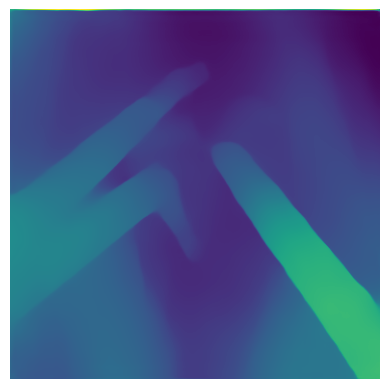

In [21]:
from PIL import Image
import torch
from torch import nn
import requests
from torchvision import transforms
import matplotlib.pyplot as plt

# img_url = 'https://www.animalfunfacts.net/images/stories/pets/dogs/pembroke_welsh_corgi_l.jpg'
img_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
img_raw = Image.open(requests.get(img_url, stream=True).raw)
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize((384, 384)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
img = transform(img_raw)[None]



%cd /content/DPT
from dpt.models import DPTDepthModel

net_w = net_h = 384
model = DPTDepthModel(
    path='/content/DPT/dpt_large-midas-2f21e586.pt',
    backbone="vitl16_384",
    non_negative=True,
    enable_attention_hooks=False,
)

pred = model(img)
plt.imshow(pred[0].detach().numpy(), cmap='gray')
plt.axis('OFF')

V2: Implement DPTDepthModel and import remaining

input torch.Size([1, 3, 384, 384])
inv_depth torch.Size([1, 384, 384])


(-0.5, 383.5, 383.5, -0.5)

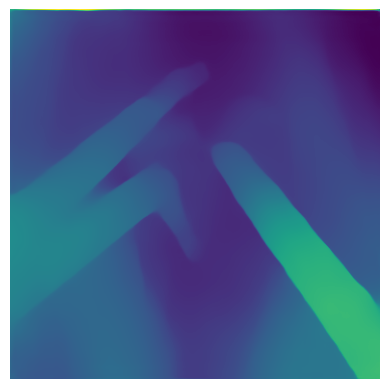

In [26]:
from dpt.models import DPT
from dpt.blocks import Interpolate
import torch
from torch import nn


class DPTDepthModel(DPT):
    def __init__(
        self, path=None, non_negative=True, scale=1.0, shift=0.0, invert=False, **kwargs
    ):
        features = kwargs["features"] if "features" in kwargs else 256

        self.scale = scale
        self.shift = shift
        self.invert = invert

        head = nn.Sequential(
            nn.Conv2d(features, features // 2, kernel_size=3, stride=1, padding=1),
            Interpolate(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(features // 2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True) if non_negative else nn.Identity(),
            nn.Identity(),
        )

        super().__init__(head, **kwargs)

        if path is not None:
            # self.load(path)
            parameters = torch.load(path, map_location=torch.device("cpu"))
            if "optimizer" in parameters:
                parameters = parameters["model"]
            self.load_state_dict(parameters)

    def forward(self, x):
        print('input', x.shape)
        inv_depth = super().forward(x).squeeze(dim=1)
        print('inv_depth', inv_depth.shape)
        return inv_depth

net_w = net_h = 384
model = DPTDepthModel(
    path='/content/DPT/dpt_large-midas-2f21e586.pt',
    backbone="vitl16_384",
    non_negative=True,
    enable_attention_hooks=False,
)
pred = model(img)
plt.imshow(pred[0].detach().numpy(), cmap='gray')
plt.axis('OFF')

V3: Implement most of the Classes

input torch.Size([1, 3, 384, 384])
x forward torch.Size([1, 3, 384, 384])
layers torch.Size([1, 256, 96, 96]) torch.Size([1, 512, 48, 48]) torch.Size([1, 1024, 24, 24]) torch.Size([1, 1024, 12, 12])
layer_1_rn torch.Size([1, 256, 96, 96]) torch.Size([1, 256, 48, 48]) torch.Size([1, 256, 24, 24]) torch.Size([1, 256, 12, 12])
paths: torch.Size([1, 256, 24, 24]) torch.Size([1, 256, 48, 48]) torch.Size([1, 256, 96, 96]) torch.Size([1, 256, 192, 192])
out: torch.Size([1, 1, 384, 384])
inv_depth torch.Size([1, 384, 384])


(-0.5, 383.5, 383.5, -0.5)

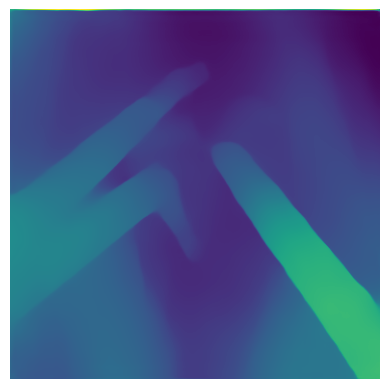

In [29]:
from dpt.base_model import BaseModel
from dpt.blocks import Interpolate, FeatureFusionBlock_custom, _make_encoder, forward_vit
import torch
from torch import nn

def _make_fusion_block(features, use_bn):
    return FeatureFusionBlock_custom(
        features,
        nn.ReLU(False),
        deconv=False,
        bn=use_bn,
        expand=False,
        align_corners=True,
    )

class DPT(BaseModel):
    def __init__(
        self,
        head,
        features=256,
        backbone="vitb_rn50_384",
        readout="project",
        channels_last=False,
        use_bn=False,
        enable_attention_hooks=False,
    ):

        super(DPT, self).__init__()

        self.channels_last = channels_last

        hooks = {
            "vitb_rn50_384": [0, 1, 8, 11],
            "vitb16_384": [2, 5, 8, 11],
            "vitl16_384": [5, 11, 17, 23],
        }

        # Instantiate backbone and reassemble blocks
        self.pretrained, self.scratch = _make_encoder(
            backbone,
            features,
            False,  # Set to true of you want to train from scratch, uses ImageNet weights
            groups=1,
            expand=False,
            exportable=False,
            hooks=hooks[backbone],
            use_readout=readout,
            enable_attention_hooks=enable_attention_hooks,
        )

        self.scratch.refinenet1 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet2 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet3 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet4 = _make_fusion_block(features, use_bn)

        self.scratch.output_conv = head

    def forward(self, x):
        if self.channels_last == True:
            x.contiguous(memory_format=torch.channels_last)
        print('x forward', x.shape)
        layer_1, layer_2, layer_3, layer_4 = forward_vit(self.pretrained, x)
        print('layers', layer_1.shape, layer_2.shape, layer_3.shape, layer_4.shape)
        layer_1_rn = self.scratch.layer1_rn(layer_1)
        layer_2_rn = self.scratch.layer2_rn(layer_2)
        layer_3_rn = self.scratch.layer3_rn(layer_3)
        layer_4_rn = self.scratch.layer4_rn(layer_4)
        print('layer_1_rn', layer_1_rn.shape, layer_2_rn.shape, layer_3_rn.shape,layer_4_rn.shape,)

        path_4 = self.scratch.refinenet4(layer_4_rn)
        path_3 = self.scratch.refinenet3(path_4, layer_3_rn)
        path_2 = self.scratch.refinenet2(path_3, layer_2_rn)
        path_1 = self.scratch.refinenet1(path_2, layer_1_rn)
        print('paths:', path_4.shape, path_3.shape, path_2.shape, path_1.shape)
        out = self.scratch.output_conv(path_1)
        print('out:', out.shape)
        return out

class DPTDepthModel(DPT):
    def __init__(
        self, path=None, non_negative=True, scale=1.0, shift=0.0, invert=False, **kwargs
    ):
        features = kwargs["features"] if "features" in kwargs else 256

        self.scale = scale
        self.shift = shift
        self.invert = invert

        head = nn.Sequential(
            nn.Conv2d(features, features // 2, kernel_size=3, stride=1, padding=1),
            Interpolate(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(features // 2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True) if non_negative else nn.Identity(),
            nn.Identity(),
        )

        super().__init__(head, **kwargs)

        if path is not None:
            # self.load(path)
            parameters = torch.load(path, map_location=torch.device("cpu"))
            if "optimizer" in parameters:
                parameters = parameters["model"]
            self.load_state_dict(parameters)

    def forward(self, x):
        print('input', x.shape)
        inv_depth = super().forward(x).squeeze(dim=1)
        print('inv_depth', inv_depth.shape)
        return inv_depth

net_w = net_h = 384
model = DPTDepthModel(
    path='/content/DPT/dpt_large-midas-2f21e586.pt',
    backbone="vitl16_384",
    non_negative=True,
    enable_attention_hooks=False,
)
pred = model(img)
plt.imshow(pred[0].detach().numpy(), cmap='gray')
plt.axis('OFF')

DPT from Huggingface library:

In [6]:
!pip -q install transformers

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


input torch.Size([1, 3, 384, 384])
embedded output: torch.Size([1, 577, 1024])
encoder output torch.Size([1, 577, 1024])
pooled_output None
head_outputs torch.Size([1, 577, 1024])
outputs torch.Size([1, 577, 1024])
hidden_states1 torch.Size([1, 577, 1024])
hidden_states_neck torch.Size([1, 256, 24, 24])
predicted_depth torch.Size([1, 384, 384])


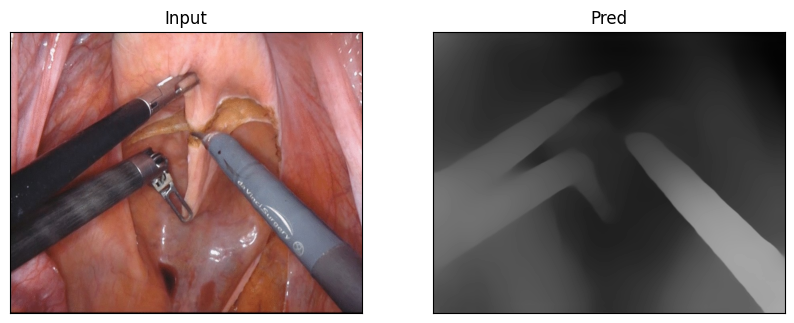

In [11]:
import torch
from torch import nn
from transformers import DPTFeatureExtractor, DPTForDepthEstimation, DPTConfig
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import transforms

#depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
class DPT_CUSTOM(nn.Module):
    def __init__(self,):
        super(DPT_CUSTOM, self).__init__()
        self.dpt = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
        self.config = DPTConfig.from_pretrained("Intel/dpt-large")
        self.embedding = self.dpt.dpt.embeddings
        self.encoder = self.dpt.dpt.encoder
        self.get_head_mask = self.dpt.dpt.get_head_mask
        self.layernorm = self.dpt.dpt.layernorm
        self.pooler = self.dpt.dpt.pooler
        self.neck = self.dpt.neck
        self.head = self.dpt.head

    def forward(self, inputs, head_mask=None, output_attentions=None, output_hidden_states=True, return_dict=None):
        print('input', inputs.shape)
        embedding_output = self.embedding(inputs)
        embedding_last_hidden_states = embedding_output[0]
        print('embedded output:', embedding_last_hidden_states.shape)
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
        encoder_outputs = self.encoder(
            embedding_last_hidden_states,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        print('encoder output', sequence_output.shape)
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None
        print('pooled_output', pooled_output)

        head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
        print('head_outputs', head_outputs[0].shape)
        outputs = head_outputs + encoder_outputs[1:] + embedding_output[1:]
        print('outputs', outputs[0].shape)
        hidden_states = outputs.hidden_states if return_dict else outputs[1]
        hidden_states = [
            feature for idx, feature in enumerate(hidden_states[1:]) if idx in self.config.backbone_out_indices
        ]
        print('hidden_states1', hidden_states[0].shape)

        hidden_states = self.neck(hidden_states)
        print('hidden_states_neck', hidden_states[0].shape)
        predicted_depth = self.head(hidden_states)
        print('predicted_depth', predicted_depth.shape)
        return predicted_depth


device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
img_raw = Image.open(requests.get(img_url, stream=True).raw)
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize((384, 384)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
image = transform(img_raw)[None]
depth_estimation_custom = DPT_CUSTOM()

with torch.no_grad():
    predicted_depth = depth_estimation_custom(image)
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy()

num_img = 2
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(img_raw)
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');

Clean Code:

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


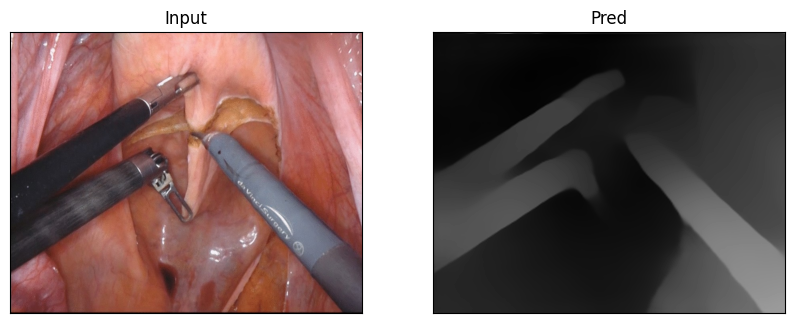

In [12]:
import torch
from torch import nn
from transformers import DPTFeatureExtractor, DPTForDepthEstimation, DPTConfig
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import transforms

#depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
class DPT_CUSTOM(nn.Module):
    def __init__(self,):
        super(DPT_CUSTOM, self).__init__()
        self.dpt = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
        self.config = DPTConfig.from_pretrained("Intel/dpt-large")
        self.embedding = self.dpt.dpt.embeddings
        self.encoder = self.dpt.dpt.encoder
        self.get_head_mask = self.dpt.dpt.get_head_mask
        self.layernorm = self.dpt.dpt.layernorm
        self.pooler = self.dpt.dpt.pooler
        self.neck = self.dpt.neck
        self.head = self.dpt.head

    def forward(self, inputs, head_mask=None, output_attentions=None, output_hidden_states=True, return_dict=None):
        embedding_output = self.embedding(inputs)
        embedding_last_hidden_states = embedding_output[0]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
        encoder_outputs = self.encoder(
            embedding_last_hidden_states,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
        outputs = head_outputs + encoder_outputs[1:] + embedding_output[1:]
        hidden_states = outputs.hidden_states if return_dict else outputs[1]
        hidden_states = [
            feature for idx, feature in enumerate(hidden_states[1:]) if idx in self.config.backbone_out_indices
        ]

        hidden_states = self.neck(hidden_states)
        predicted_depth = self.head(hidden_states)
        return predicted_depth


device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
img_raw = Image.open(requests.get(img_url, stream=True).raw)
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
image = transform(img_raw)[None]
depth_estimation_custom = DPT_CUSTOM()

with torch.no_grad():
    predicted_depth = depth_estimation_custom(image)
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy()

num_img = 2
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(img_raw)
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');